## Setup Environment

Before we get started, we need to install several Python packages that we'll use throughout this notebook. 

1. **torch and torchvision**: PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Torchvision is a package that provides access to popular datasets, model architectures, and image transformations for computer vision.

2. **pytorch-lightning and pytorch-lightning-bolts**: PyTorch Lightning is a lightweight PyTorch wrapper for high-performance AI research. It structures your code so it's decoupled and reusable, while ensuring all the right best practices are applied. PyTorch Lightning Bolts is a collection of PyTorch Lightning implementations of popular models, so you don't have to start from scratch.

3. **torchmetrics**: A library that provides easy access to various evaluation metrics in PyTorch.

4. **tensorboard-plugin-profile**: A plugin for TensorBoard, a tool for providing the measurements and visualizations needed during the machine learning workflow. This plugin specifically provides the capability to profile your TensorFlow or PyTorch training jobs.

5. **numpy, pandas, matplotlib, seaborn**: Widely used Python libraries for data manipulation, analysis, and visualization.

6. **opencv-python**: A Python wrapper for the original OpenCV library which is an open source computer vision and machine learning software library.

7. **scikit-learn**: A machine learning library for Python that features various algorithms like support vector machine, random forests, and k-neighbours, and it also supports Python numerical and scientific libraries like NumPy and SciPy.

8. **tensorboardX, tensorboard**: TensorBoard provides the visualization and tooling needed for machine learning experimentation. TensorBoardX is a nice interface communicating TensorBoard, allowing users to log PyTorch models and metrics into a format TensorBoard understands.

9. **tqdm**: A Python library that provides fast, extensible progress bars for loops.

In the code cell below, we install these packages using pip, Python's package manager. The exclamation point at the beginning of each line tells Jupyter Notebook to execute the line as a shell command.

After installing the packages, we enable the inline backend for matplotlib with the magic command `%matplotlib inline`. This makes matplotlib plots appear inline within the notebook, directly below the codld our machine learning model.

In [1]:
!pip install torch torchvision pytorch-lightning pytorch-lightning-bolts torchmetrics tensorboard-plugin-profile
!pip install numpy pandas matplotlib opencv-python scikit-learn tensorboardX tensorboard tqdm seaborn
%matplotlib inline

## Import Libraries

Next, we import the necessary libraries. 

1. **Standard library**: We import `os` and `random` from Python's standard library. `os` allows us to interact with the operating system, while `random` allows us to generate random numbers.

2. **Third-party libraries**: We import a number of third-party libraries for various purposes. `numpy` and `pandas` are for data manipulation and analysis. `matplotlib` and `seaborn` are for data visualization. `PIL` (Pillow) is for opening, manipulating, and saving many different image file formats. `sklearn.model_selection` provides functions to split the dataset into training set and test set. `sklearn.metrics` provides functions to calculate the Mean Squared Error, Mean Absolute Error, and the R2 Score, which are common metrics used in regression problems. `tqdm` provides progress bars for visualizing the status of loops.

3. **PyTorch and related libraries**: `torch` is the main PyTorch library, and `torch.nn` and `torch.nn.functional` provide classes and functions for building neural networks. `torch.optim` provides classes for various optimization algorithms.

4. **torchvision**: `torchvision` provides utilities for working with image data, including pre-trained models, utilities for image transformation, and popular datasets.

5. **PyTorch Lightning**: We use PyTorch Lightning, a lightweight wrapper around PyTorch, to organize our machine learning code. It provides classes for defining machine learning models, managing data, and training models.

6. **Torchmetrics**: A library that provides easy access to various evaluation metrics in PyTorch.

Note: The command `os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'` is used to limit TensorFlow debugging output to ERROR level. This isn't necessary if you're not using TensorFlo's included here in case you decide to use it in the future.

In [2]:
# Standard library
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # To limit TensorFlow debugging output
import random
import warnings

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Sklearn metrics
from tqdm import tqdm

# PyTorch and related libraries
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# torchvision
import torchvision
from torchvision import transforms, models
from torchvision.models import densenet121, DenseNet121_Weights

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, DeviceStatsMonitor, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# Torchmetrics
import torchmetrics  
from torchmetrics import MeanSquaredError, MeanAbsoluteError  
torch.set_float32_matmul_precision("high")

# Print versions
print(f"Torchvision: {torchvision.__version__}")
print(f"PyTorch Lightning: {pl.__version__}")  # <--- TYPO FIX
print(f"Torch: {torch.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Torchmetrics: {torchmetrics.__version__}")  # Print torchmetrics version


Torchvision: 0.15.2+cu117
PyTorch Lightning: 2.0.3
Torch: 2.0.1+cu117
Numpy: 1.23.5
Pandas: 2.0.2
Torchmetrics: 0.11.4


## Constants

In this section, we define the constants that we'll use in our code. 

1. **Paths**: We define the path to the directory where our data is stored, the path to the directory where our key slices are stored, and the path to the CSV file containing our labels.

2. **Image settings**: We define the size of the images we'll be working with, and the number of classes in our data. We also assume that the grayscale images have been standardized to have values between 0 and 1, and so we define the mean and standard deviation of these grayscale images.

3. **Training settings**: We define the batch size for training and validation, the number of epochs for training, the learning rate for the optimizer, the proportion of data to use for training (with the rest being used for validation), and the number of CPU cores to useOptimizer settings. 

4. **Optimizer settings**: We define the optimizer to use.e set correctly.

In [3]:
# Constants

# Path to data
DATA_DIR: str = os.path.join(os.getcwd(), 'data/Images_png')
KEY_DATA_DIR: str = os.path.join(os.getcwd(), 'data/Key_slices')
CSV_PATH: str = os.path.join(os.getcwd(), 'data/DL_info.csv')  # The path to the CSV file containing the labels

# Image settings
IMAGE_SIZE: int = 224  # We will resize all images to this size. ResNet, for example, expects this input size
NUM_CLASSES: int = 4   # the bounding box

# Assume the grayscale images have been standardized to have values between 0 and 1
GRAYSCALE_MEAN = 0.5
GRAYSCALE_STD = 0.5

# Training settings
BATCH_SIZE: int = 32  # The batch size for training and validation
EPOCHS: int = 200  # The number of epochs for training. Adjust based on your observation of the model performance
LEARNING_RATE: float = 1e-3  # Learning rate for the optimizer. This may need to be adjusted based on the model's performance
TRAIN_SPLIT: float = 0.8  # The proportion of data to use for training. The rest will be used for validation
CPU_CORES: int = 8

# Optimizer settings
OPTIMIZER: str = 'Adam'  # The optimizer to use. You can change this to 'SGD' or other optimizers as needed
LR_MODE: str = 'min'
LR_FACTOR: float = 0.1
LR_PATIENCE: int = 3
ES_PATIENCE: int = 5

# Print to check if the paths and values are correct
print(DATA_DIR)
print(KEY_DATA_DIR)
print(CSV_PATH)
print(BATCH_SIZE)
print(EPOCHS)
print(OPTIMIZER)


/home/jbourne/projects/bourne/reagan/deep_lesion/data/Images_png
/home/jbourne/projects/bourne/reagan/deep_lesion/data/Key_slices
/home/jbourne/projects/bourne/reagan/deep_lesion/data/DL_info.csv
32
200
Adam


## Helper Functions and Data Visualization

In this section, we define some helper functions for our work. 

1. **`bbox_iou(box1, box2)`**: This function calculates the Intersection over Union (IoU) of two bounding boxes. IoU is a measure of the overlap between two bounding boxes. It is used in object detection to measure the accuracy of the predicted bounding box against the ground truth bounding box.

2. **`visualize_and_print_stats(image)`**: This function displays an image and prints its minimum, maximum, mean, and standard deviation values. This is a useful tool for exploring your data and understanding its properties.

3. **`To3Channels(object)`**: This is a class that defines a callable object to convert a 1-channel grayscale image to a 3-channel image by duplicating the channel three times. This is useful when working with models that expect 3-channel input.

Lastly, we display a random image from the dataset to understand what kind of data we are dealing with.

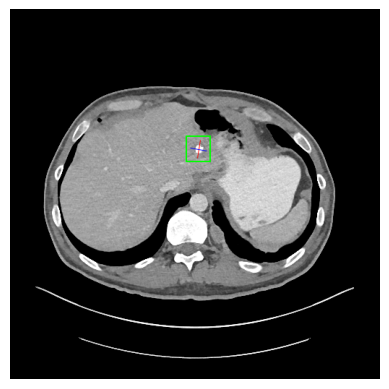

In [4]:
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes.
    """
    # Obtain the intersection coordinates
    x1 = torch.max(box1[..., 0], box2[..., 0])
    y1 = torch.max(box1[..., 1], box2[..., 1])
    x2 = torch.min(box1[..., 2], box2[..., 2])
    y2 = torch.min(box1[..., 3], box2[..., 3])

    # Compute the area of intersection
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Compute the area of both bounding boxes
    box1_area = (box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1])
    box2_area = (box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1])

    # Compute the IoU
    iou = intersection / (box1_area + box2_area - intersection + 1e-6)
    
    return iou


def visualize_and_print_stats(image):
    """Display an image and print its min, max, mean, and std."""
    plt.imshow(image)
    plt.show()

    print(f"Image min: {image.min()}")
    print(f"Image max: {image.max()}")
    print(f"Image mean: {image.mean()}")
    print(f"Image std: {image.std()}")

class To3Channels(object):
    """Convert a 1-channel grayscale image to a 3-channel image by duplicating the channel three times."""
    def __call__(self, image):
        return image.repeat(3, 1, 1)

# Get the list of images
images = os.listdir(KEY_DATA_DIR)

# Choose a random image
image = random.choice(images)

# Load the image
path = os.path.join(KEY_DATA_DIR, image)

# Show the image
image = Image.open(path)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


## Creating the DeepLesionModel

The `DeepLesionModel` class inherits from the `pl.LightningModule` which is a part of the PyTorch Lightning library. This library is a lightweight PyTorch wrapper for high-performance AI research. The class contains several methods that serve different purposes in the process of training a deep learning model.

Here are the methods explained:

### `__init__`
This method is used to initialize the `DeepLesionModel` object. The initialization involves setting up the base model, which in this case is the DenseNet121, a convolutional neural network that has achieved state-of-the-art performance on several benchmark datasets. The pretrained DenseNet121 model's fully connected layer is replaced with a new fully connected layer that is designed to output 4 values which correspond to the coordinates of the bounding box (x, y, width, height).

Also, the Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), Symmetric Mean Absolute Percentage Error (SMAPE), and Mean Squared Logarithmic Error (MSLE) metrics are initialized in this method. These metrics are used to evaluate the performance of the model during the training and validation process.

### `forward`
This method defines the forward propagation process of the neural network. In this case, it simply involves passing the input tensor `x` through the base model.

### `training_step`
This method defines a single step in the training process. The input tensor `x` is passed through the model, and the output is compared to the target tensor `y` to calculate the loss. The loss is logged for tracking purposes. Additionally, metrics such as MAE, MAPE, SMAPE, MSLE, and Intersection over Union (IoU) are computed for the predictions and logged.

### `on_train_epoch_end`
At the end of each training epoch, this method computes and logs the average training loss for that epoch.

### `validation_step`
This method is similar to `training_step`, but it is used during the validation phase of the training process. The loss and metrics computed are based on the model's performance on the validation set.

### `on_validation_epoch_end`
This method is called at the end of each validation epoch and computes the average validation loss for the epoch, which is then logged.

### `test_step`
This method is called for each batch of the test dataset. It is similar to `training_step` and `validation_step`, but it's used for evaluating the model's performance on the unseen test data. The computed loss and metrics are logged.

### `configure_optimizers`
This method is used to specify the optimizer used during training. In this case, the Adam optimizer is used with a specified learning rate.

### `prepare_data`
This method is used to prepare the datasets for training, validation, and testing. The data is read from a CSV file and split according to the 'Train_Val_Test' column in the data. A `DeepLesionDataset` object is created for each split of the data, and a series of transforms are applied to the images, including converting the images to tensors and normalizing the pixel values.

### `train_dataloader`, `val_dataloader`, `test_dataloader`
These methods return PyTorch DataLoader objects for the training, validation, and test sets, respectively. These DataLoader objects are used to load the data in batches during the training, validation, and testing phases.

In [5]:
class DeepLesionModel(pl.LightningModule):
    def __init__(self, learning_rate=LEARNING_RATE, batch_size=32):
        super().__init__()

        # Base model (DenseNet121)
        self.base_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        num_features = self.base_model.classifier.in_features

        # Replace the fully connected layer for bounding box regression
        self.base_model.classifier = torch.nn.Linear(num_features, 4)

        # Hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # metrics
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mape = torchmetrics.MeanAbsolutePercentageError()
        self.smape = torchmetrics.SymmetricMeanAbsolutePercentageError()
        self.mlse = torchmetrics.MeanSquaredLogError()

        # placeholders for losses
        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, x):
        return self.base_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.smooth_l1_loss(y_hat, y)
        self.log('train_loss', loss)
        self.training_step_outputs.append(loss)
        
        # Calculate metrics on the train set
        self.log("train_mae", self.mae(y_hat, y))
        self.log("train_mape", self.mape(y_hat, y))
        self.log("train_smape", self.smape(y_hat, y))
        self.log("train_mlse", self.mlse(y_hat, y))
    
        iou = bbox_iou(y_hat, y).mean()
        self.log('train_iou', iou)
    
        return loss

    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        self.log("train_loss_epoch", epoch_average)
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.smooth_l1_loss(y_hat, y)
        self.log('val_loss', val_loss)
        self.validation_step_outputs.append(val_loss)
        
        # Calculate metrics on the validation set
        self.log("val_mae", self.mae(y_hat, y))
        self.log("val_mape", self.mape(y_hat, y))
        self.log("val_smape", self.smape(y_hat, y))
        self.log("val_mlse", self.mlse(y_hat, y))

        iou = bbox_iou(y_hat, y).mean()
        self.log('val_iou', iou)

        return val_loss

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        self.log("val_loss_epoch", epoch_average)
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.smooth_l1_loss(y_hat, y)
        self.log('test_loss', test_loss)

        # Calculate metrics on the test set
        self.log("test_mae", self.mae(y_hat, y))
        self.log("test_mape", self.mape(y_hat, y))
        self.log("test_smape", self.smape(y_hat, y))
        self.log("test_mlse", self.mlse(y_hat, y))
        
        iou = bbox_iou(y_hat, y).mean()
        self.log('test_iou', iou)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode=LR_MODE, factor=LR_FACTOR, patience=LR_PATIENCE),
            'monitor': 'val_loss',  # metric to monitor for lr scheduling
        }
        return [optimizer], [lr_scheduler]
    
    def prepare_data(self):
        # Prepare the datasets here
        full_dataset = pd.read_csv(CSV_PATH)  # replace with the path to your dataset
    
        train_df = full_dataset[full_dataset['Train_Val_Test'] == 1]
        val_df = full_dataset[full_dataset['Train_Val_Test'] == 2]
        test_df = full_dataset[full_dataset['Train_Val_Test'] == 3]
    
        self.train_dataset = DeepLesionDataset(
            image_dir=KEY_DATA_DIR, 
            df=train_df, 
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([GRAYSCALE_MEAN], [GRAYSCALE_STD])
            ])
        )
        
        self.val_dataset = DeepLesionDataset(
            image_dir=KEY_DATA_DIR, 
            df=val_df, 
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([GRAYSCALE_MEAN], [GRAYSCALE_STD])
            ])
        )
        
        self.test_dataset = DeepLesionDataset(
            image_dir=KEY_DATA_DIR, 
            df=test_df, 
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([GRAYSCALE_MEAN], [GRAYSCALE_STD])
            ])
        )

        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=CPU_CORES)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=CPU_CORES)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=CPU_CORES)


## Data Preparation and Transformation

These classes are related to the preparation and transformation of the data used to train the DeepLesion model.

### `ResizeAndAdjustBbox`
This class is a transformation that resizes an image and its corresponding bounding box. The bounding box is a rectangle that encapsulates the region of interest in an image (in this case, the lesion). When an image is resized, the coordinates of the bounding box also need to be adjusted to fit the new image size.

The `__call__` method of the `ResizeAndAdjustBbox` class takes as input a tuple containing an image and its corresponding bounding box, resizes the image to the specified size, and adjusts the bounding box coordinates accordingly. The resized image and adjusted bounding box are returned.

### `DeepLesionDataset`
This class represents the dataset of images and their corresponding bounding boxes. This class inherits from the `torch.utils.data.Dataset` class which is an abstract class representing a dataset in PyTorch. This class is typically subclassed to create custom datasets.

In the `__init__` method, the directory containing the images, the dataframe containing the image metadata (including bounding box coordinates), and the image transformations to apply are passed as arguments.

The `__len__` method returns the number of images in the dataset.

The `__getitem__` method is used to load and return an image and its corresponding bounding box from the dataset at the specified index. The image is loaded as a grayscale image, the bounding box is extracted from the dataframe, the `ResizeAndAdjustBbox` transform is applied to the image and bounding box, and any other specified transforms are applied to the image. The image and adjusted bounding box are then returned.

In [6]:
class ResizeAndAdjustBbox(object):
    """Resizes the image and adjusts the bounding box coordinates accordingly."""
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        image, bbox = sample
        w, h = image.size
        new_w, new_h = self.size

        # Resize the image
        image = transforms.Resize(self.size)(image)

        # Adjust the bounding box coordinates
        bbox = [bbox[0]*new_w/w, bbox[1]*new_h/h, bbox[2]*new_w/w, bbox[3]*new_h/h]

        return image, torch.tensor(bbox)

class DeepLesionDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.resize_and_adjust_bbox = ResizeAndAdjustBbox((IMAGE_SIZE, IMAGE_SIZE))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['File_name'])
    
        # Load the image as grayscale
        image = Image.open(img_path).convert('L')
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)  # Convert back to PIL image
    
        # Get bounding box
        bbox = list(map(float, row['Bounding_boxes'].split(',')))
    
        # Apply the resize and adjust bbox transform
        image, bbox = self.resize_and_adjust_bbox((image, bbox))
    
        # Apply other transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, bbox



## Data Module Definition

A PyTorch Lightning data module encapsulates the data loading and preparation process. It allows for easy reuse of data loading code across different models and also helps in ensuring that data-related code is organized and separated from model training code. 

The `DeepLesionDataModule` class is the data module for the DeepLesion model. It inherits from the `pl.LightningDataModule` class and defines methods for preparing the data and loading it into a format that can be used by PyTorch.

In the `__init__` method, it takes in the directory containing the data, the path to the CSV file containing the metadata of the dataset, and the batch size to be used in training. It also defines the transformations to be applied to the images in the dataset. These transformations include converting the image to a PyTorch tensor, expanding it to 3 channels, and normalizing it with the mean and standard deviation values of the ImageNet dataset.

In the `setup` method, it reads the CSV file to obtain the metadata of the dataset and filters the data to create training, validation, and testing datasets based on the 'Train_Val_Test' column. It then creates instances of the `DeepLesionDataset` class for each of these datasets.

The `train_dataloader`, `val_dataloader`, and `test_dataloader` methods define the data loaders for the training, validation, and testing datasets respectively. These data loaders will provide batches of data to the model during training.

Finally, an instance of the `DeepLesionDataModule` class is created and its `setup` method is called to prepare the data for training.

This setup ensures that all the data-related logic is encapsulated within the data module, making it easy to use this data in different parts of the code and ensuring that the data preparation process is consistent across different runs of the code.

In [7]:


# Define DataModule
class DeepLesionDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_path, batch_size=BATCH_SIZE):
        super().__init__()
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.batch_size = batch_size
    
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert image to PyTorch tensor
            To3Channels(),  # Expand to 3 channels
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
        ])


    def setup(self, stage=None):
        # Instantiate the full dataset
        full_dataset = pd.read_csv(self.csv_path)

        # Filter rows to create training, validation and testing datasets based on the 'Train_Val_Test' column
        train_df = full_dataset[full_dataset['Train_Val_Test'] == 1]
        val_df = full_dataset[full_dataset['Train_Val_Test'] == 2]
        test_df = full_dataset[full_dataset['Train_Val_Test'] == 3]

        # Create the train, val and test datasets
        self.train_dataset = DeepLesionDataset(self.data_dir, train_df, transform=self.transform)
        self.val_dataset = DeepLesionDataset(self.data_dir, val_df, transform=self.transform)
        self.test_dataset = DeepLesionDataset(self.data_dir, test_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=8)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=8)

# Instantiate the datamodule
data_module = DeepLesionDataModule(KEY_DATA_DIR, CSV_PATH)
data_module.setup()

## Callbacks Definition

Callbacks in PyTorch Lightning provide a way to hook into the model training process at specific points to execute some code. They can be used to implement a variety of functionalities such as saving checkpoints, adjusting the learning rate, or stopping training early when the model's performance has stopped improving.

In the given code, several callbacks are defined:

1. **Early Stopping:** The `EarlyStopping` callback is used to stop the training process early if the model's performance on the validation set (measured by the `val_loss`) doesn't improve by at least `0.001` for `3` consecutive epochs. This can help save time and computational resources by stopping the training when the model is no longer making significant improvements.

2. **Model Checkpointing:** The `ModelCheckpoint` callback is used to save checkpoints of the model at the end of each epoch. The checkpoints are saved in the `.training_checkpoints` directory, with filenames given by the template `"model-{epoch:02d}-{val_loss:.2f}"`. The `save_top_k=3` argument means that only the best 3 checkpoints (measured by the `val_loss`) will be saved, and older checkpoints will be deleted. Checkpoints allow us to resume training from a certain point or to use the saved model weights for evaluation or inference later.

3. **Device Stats Monitor:** The `DeviceStatsMonitor` callback is used to log device-specific stats, such as GPU utilization and memory usage, for every training step. This can be useful for profiling and understanding resource utilization.

4. **Learning Rate Monitor:** The `LearningRateMonitor` callback is used to log the learning rate for each epoch. This can be useful for understanding how the learning rate changes over the course of training, especially if a learning rate scheduler is used.

These callbacks are added to the trainer when it is created, and they will automatically execute their code at the appropriate points during the training process.

In [8]:
# Filter out the specific UserWarning related to the checkpoint directory
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module='pytorch_lightning.callbacks.model_checkpoint',
    message='.*Checkpoint directory.*exists and is not empty.*',
)

# Configure early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", # or the metric of your choice
    min_delta=0.001,
    patience=ES_PATIENCE,
    verbose=True,
    mode="min"
)

# Configure model checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", # or the metric of your choice
    dirpath=".training_checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}", # or use a custom template of your choice
    save_top_k=3,
    mode="min",
)

device_stats_callback = DeviceStatsMonitor()

learning_rate_callback = LearningRateMonitor()


## TensorBoard and Magic Commands in Jupyter

TensorBoard is a handy tool that comes with TensorFlow, and it provides a suite of web applications for inspecting and understanding your model runs and graphs. You can track and visualize various metrics such as loss and accuracy, display images, text, and more - all within an interactive web interface.

In the Jupyter notebook, magic commands are enhancements added on top of the normal Python syntax and are prefixed by the '%' character. These magic commands are intended to solve common problems in data analysis using Python. For instance, magic commands can write content of the cell to a file, change the directory, load a script into a code cell, run a code cell, load an extension enabling extra functionality, etc.

There are two kinds of magic commands:

1. Line magics: These are commands prepended by one % character and are executed within the context of a single line of input.

2. Cell magics: These are commands that start with a double %% and they operate on multiple lines of input.

In the context of your code,

- `%load_ext tensorboard` is a line magic command that loads the tensorboard extension. This command needs to be run only once in a Jupyter notebook. The `load_ext` command is a shorthand for `Load IPython extension to load extensions by their module name.`

- `%tensorboard --logdir ./tb_logs` is another line magic command that launches TensorBoard within the notebook, specifying the log directory as `./tb_logs`. This directory contains the logs that are generated by TensorBoard while running and it will monitor this directory to track real-time changes.

To sum it up, the use of these two magic commands in Jupyter provides an embedded, interactive interface to TensorBoard right within your Jupyter notebook, which is extremely handy for real-time visualization of training logs and other model data.

In [9]:
%load_ext tensorboard
%tensorboard --logdir ./tb_logs

Reusing TensorBoard on port 6006 (pid 24059), started 19:47:25 ago. (Use '!kill 24059' to kill it.)

## Model Training

In this part, you're setting up the model training process. 

First, you instantiate your model `DeepLesionModel` with a specified learning rate. 

Next, you define a PyTorch Lightning `Trainer` which contains most of the boilerplate training loop logic. 

In the `Trainer`, you specify the following parameters:

- `max_epochs`: The maximum number of epochs to train the model.
- `callbacks`: Callbacks you created in the previous cells are specified here. They serve for early stopping, model checkpointing, monitoring device stats, and tracking learning rate.
- `accumulate_grad_batches`: This is gradient accumulation. It is a simple trick to allow you to effectively batch your data in larger sets which can lead to more stable training dynamics.
- `precision`: This is the precision of your model training. You're using mixed precision ('16-mixed') which can speed up the training and reduce memory usage without significant loss of model accuracy.
- `accelerator`: The hardware accelerator to use for training, here it is set to automatically use available GPU(s) if available, else CPU.
- `strategy`: Training strategy, here also set to automatic.
- `devices`: Number of devices to train on (GPUs/TPUs), here also set to automatic.
- `logger`: Logger to track the training progress. In this case, you're using a `TensorBoardLogger` which will log your metrics to a folder that can be visualized using TensorBoard.

Then, you clear any cached memory with `torch.cuda.empty_cache()` to free up some GPU memory before training starts.

Finally, you fit the model to your data by calling `trainer.fit(model, data_module)`. This starts the training process with the provided model and data. The `fit` function handles the full optimization routine: it initializes the optimizer, conducts the forward and backward passes through the network, updates the weights, and repeats the process for the specified number of epochs. The progress of training will be logged by the specified logger and can be visualized in real-time in TensorBoard. 

Remember that the training process can take a considerable amount of time depending on the complexity of your model, the amount of data you have, and the computational resources at your disposal.

In [ ]:
# Instantiate the model
model = DeepLesionModel(learning_rate=LEARNING_RATE)

# Define PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[
        early_stop_callback,
        checkpoint_callback,
        device_stats_callback,
        learning_rate_callback,
    ],
    accumulate_grad_batches=4,
    precision='16-mixed',
    accelerator="auto",
    strategy="auto",
    devices="auto",
    logger=TensorBoardLogger("tb_logs", name="deep_lesion") # Use TensorBoard to log the metrics
)

torch.cuda.empty_cache()

# Train the model
trainer.fit(model, data_module)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/deep_lesion
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                                 | Params
--------------------------------------------------------------------
0 | base_model | DenseNet                             | 7.0 M 
1 | mae        | MeanAbsoluteError                    | 0     
2 | mape       | MeanAbsolutePercentageError          | 0     
3 | smape      | SymmetricMeanAbsolutePercentageError | 0     
4 | mlse       | MeanSquaredLogError                  | 0     
--------------------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.832    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

## Model Testing and Evaluation Metrics

After training the model, you will want to test its performance on unseen data. You do this by calling the `trainer.test(model, datamodule=data_module)`. This will load the test data, feed it through the model, calculate the loss and the specified metrics, and log the results. 

Let's break down each of the metrics that are printed in the next few lines:

1. `MAE` (Mean Absolute Error): This is an average of the absolute differences between the predictions and the actual values. It measures how close the predictions are to the actual values. The lower the MAE, the better the model's performance.

2. `MAPE` (Mean Absolute Percentage Error): This is a measure of prediction accuracy of a forecasting method in statistics. It expresses the error as a percentage, providing a relative measure of the absolute error.

3. `SMAPE` (Symmetric Mean Absolute Percentage Error): Similar to MAPE but it is symmetric. It can be better than MAPE when actual observation values are close to zero.

4. `MLSE` (Mean Squared Logarithmic Error): This measures the ratio between the true and predicted values. It's useful when the target variable covers a large range of values.

5. `IoU` (Intersection over Union): In the context of bounding boxes predictions, IoU measures the overlap between 2 boundaries. We use it to measure how close the predicted bounding box is to the actual bounding box. The higher the IoU, the better the model's performance in predicting bounding boxes.

All these metrics together give a comprehensive understanding of the model's performance. Some models might perform better on one metric but worse on another, so it's useful to consider all these metrics together when evaluating the model's performance.

In [ ]:
# Test the model
trainer.test(model, datamodule=data_module)

# Access the logged test metrics
print(f"Test MAE: {trainer.logged_metrics['test_mae']}")
print(f"Test MAPE: {trainer.logged_metrics['test_mape']}")
print(f"Test SMAPE: {trainer.logged_metrics['test_smape']}")
print(f"Test MLSE: {trainer.logged_metrics['test_mlse']}")
print(f"Test IoU: {trainer.logged_metrics['test_iou']}")


## Displaying Image, Ground Truth and Predicted Bounding Boxes

The function `imshow` is used to display an image, along with the ground truth and predicted bounding boxes, if they are provided.

The input to the function `inp` is a PyTorch tensor representing an image. If the image is grayscale, it first replicates the single channel to make it a 3-channel image (this is because Matplotlib expects either a single channel grayscale image or a 3-channel RGB image for display).

The image tensor's values are then de-normalized using the mean and standard deviation values that were used for normalizing the original image. This is necessary because the original image was normalized (i.e., its pixel values were scaled down) before it was input to the model for training. We reverse this process to view the image in its original form for display.

The `imshow` function can also optionally display the ground truth and the predicted bounding boxes. Bounding boxes are represented as `Rectangle` patches and are added to the image plot. The ground truth bounding box is displayed in red and the predicted bounding box is displayed in green.

This function is helpful to visually inspect the performance of your model. You can see exactly where the model predicts a lesion to be and compare that with the actual lesion location. It helps you understand how well your model is doing and where it is making mistakes.

In [ ]:
# Get a batch of test data
inputs, classes = next(iter(model.test_dataloader()))

fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # Create a 4x4 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily index into it

for i in range(16):  # Display 16 images
    img = inputs[i]
    if img.shape[0] == 1:
        img = img.expand((3, -1, -1))
    # Compute predictions
    with torch.no_grad():
        predictions = model(img.unsqueeze(0)).squeeze(0)
    
    # Convert tensor to numpy array for display
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Display the image in the subplot
    axs[i].imshow(inp)
    axs[i].axis('off')  # Hide the axes for this subplot

    # Draw ground truth bounding box
    gt_rect = patches.Rectangle((classes[i][0], classes[i][1]), classes[i][2], classes[i][3], linewidth=2, edgecolor='r', facecolor='none')
    axs[i].add_patch(gt_rect)
    
    # Draw predicted bounding box
    pred_rect = patches.Rectangle((predictions[0], predictions[1]), predictions[2], predictions[3], linewidth=2, edgecolor='g', facecolor='none')
    axs[i].add_patch(pred_rect)

plt.tight_layout()  # Ensure the subplots do not overlap
plt.show()


In [ ]:
print(model)